In [31]:
source("../../wwa_model-fitting.R")

## **Trying to understand scaling of relative Nino3.4 index**

In [ ]:
nino34 = read.csv("nino34.csv")
nino34rel = read.csv("nino34rel.csv")
sst = read.csv("sst-anom.csv")

m_adj = c(1.2571,1.2948,1.3355,1.3746,1.3167,1.2179,1.1565,1.1505,1.1678,1.1909,1.2127,1.2350) # scaling factors taken from Climate Explorer
m_mean = sapply(1:12, function(m) { mean(sst[(as.integer(substr(sst$time,6,7)) == m) & (substr(sst$time,1,4) >= 1980) & (substr(sst$time,1,4) <= 2010),"X0"]) }) # adjustments to monthly mean

nino34_det = data.frame(time = nino34$time, X0 = nino34$X0 - sst$X0)

Warning message in file(filename, "r", encoding = encoding):
“cannot open file '../wwa_model-fitting.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [59]:
get_m <- function(df, m) { df[(as.integer(substr(df$time,6,7)) == m),] }

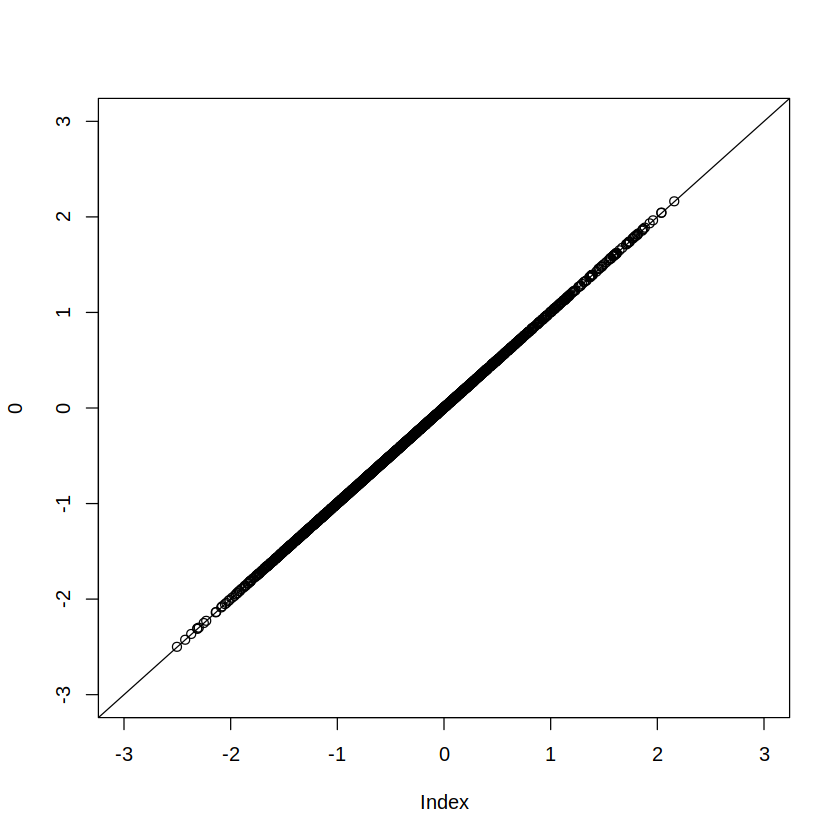

In [42]:
# confirm that this is the correct way to normalise
plot(0, type = "n", xlim = c(-3,3), ylim = c(-3,3))
abline(0,1)
for(m in 1:12) { points(get_m(nino34_det, m)$X0, get_m(nino34rel, m)$X0 / m_adj[m] - m_mean[m]) }

**So where does the scaling adjustment come from?**

A technical point is that this index will have a 20% smaller variability than the original Niño3.4 index, as a large part of the interannual variability of the 20∘ S–20∘ N series is also ENSO-driven. This is not acceptable for users who rely on fixed categorical thresholds to define events, such as the NOAA thresholds of ±0.5$^\circ$C. In addition, statistical models that use the Niño3.4 index would need refitting. We therefore propose to renormalize the series to the same variability as the original Niño3.4 series by multiplying by 1/(1 − A) with A the regression of the 20$^\circ$S–20$^\circ$N SST anomalies on the Niño3.4 index after taking year-on-year differences to isolate the ENSO signal. The regression has a strong seasonal cycle, so it is determined for each month separately (averaging over the two adjoining months in the fit to increase the signal/noise ratio).

In [35]:
A <- 1-(1/m_mean)

# How should we detrend Nino indices?

In [139]:
df = merge(read.csv("nino34_monthly.csv", col.names = c("date", "nino")), 
           read.csv("tropical-sst_monthly.csv", col.names = c("date", "tsst")))
df$year <- as.integer(substr(df$date,1,4))
df$month <- as.integer(substr(df$date,6,7))
df$i <- 1:nrow(df)

# try a loess smoother
df$nino_sm <- fitted(loess(nino ~ i, data = df, degree = 1, span = 0.5))
df$nino_res <- df$nino - df$nino_sm

In [145]:
write.csv(df, "nino-loess-smoothed.csv", row.names = F)

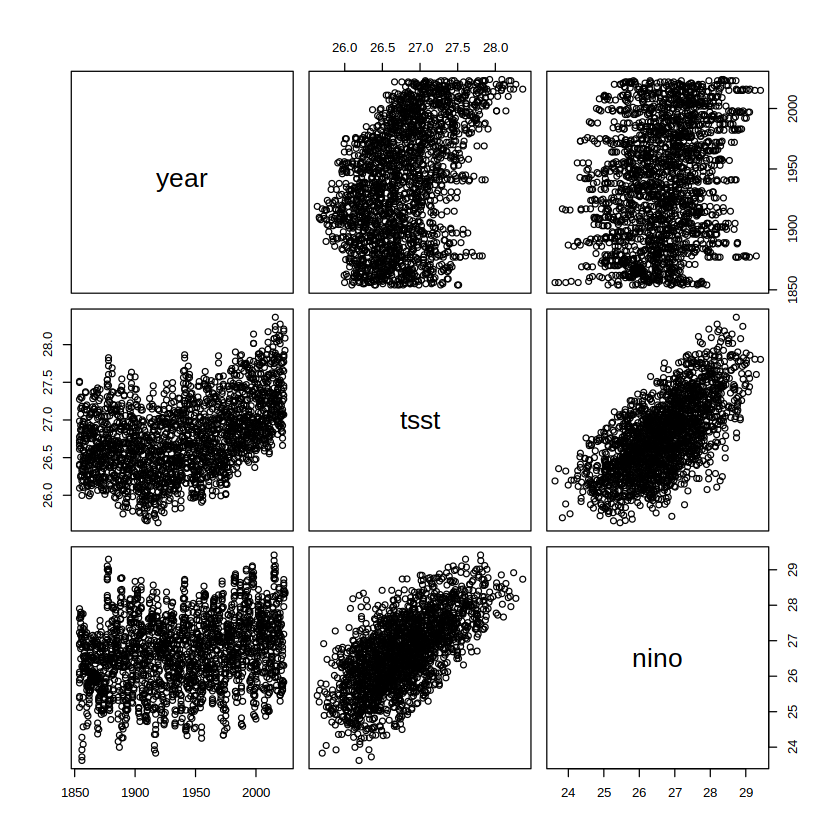

In [19]:
pairs(df[,c("year", "tsst", "nino")])

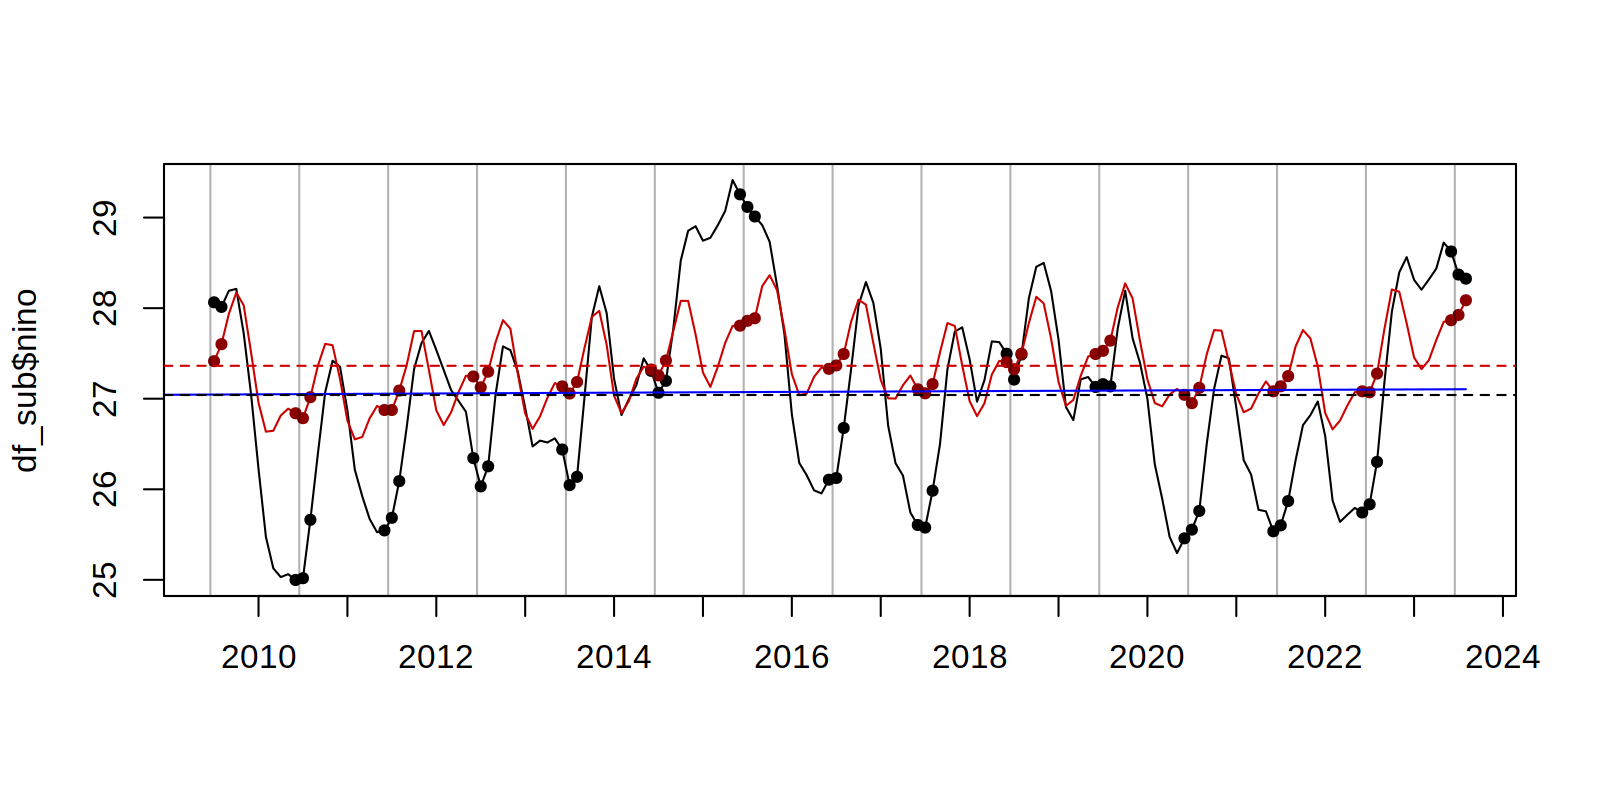

In [123]:
df_sub <- df[df$year >= 2010,]
xticks <- seq(min(df_sub$i),max(df_sub$i),12)

prep_window(c(1,2)); par(mfrow = c(1,1))
plot(df_sub$i, df_sub$nino, type = "l", xaxt = "n", xlab = "")
points(df_sub[df_sub$month %in% c(12,1,2),c("i", "nino")])
lines(df_sub$i, df_sub$tsst, col = "red3")
points(df_sub[df_sub$month %in% c(12,1,2),c("i", "tsst")], col = "red4")

lines(df$i, fitted(loess(nino ~ i, data = df)), col = "blue")

abline(v = xticks-0.5, lty = 1, col = adjustcolor("black", 0.3))

abline(h = mean(df_sub$nino), lty = 2)
abline(h = mean(df_sub$tsst), lty = 2, col = "red3")

axis(1, at = xticks+6, labels = min(df_sub$year):max(df_sub$year))

In [ ]:
# apply a 4-year rolling mean to Nino3.4
nino_ann <- sapply(unique(df$year), function(y) mean(df$nino[df$y == y]))

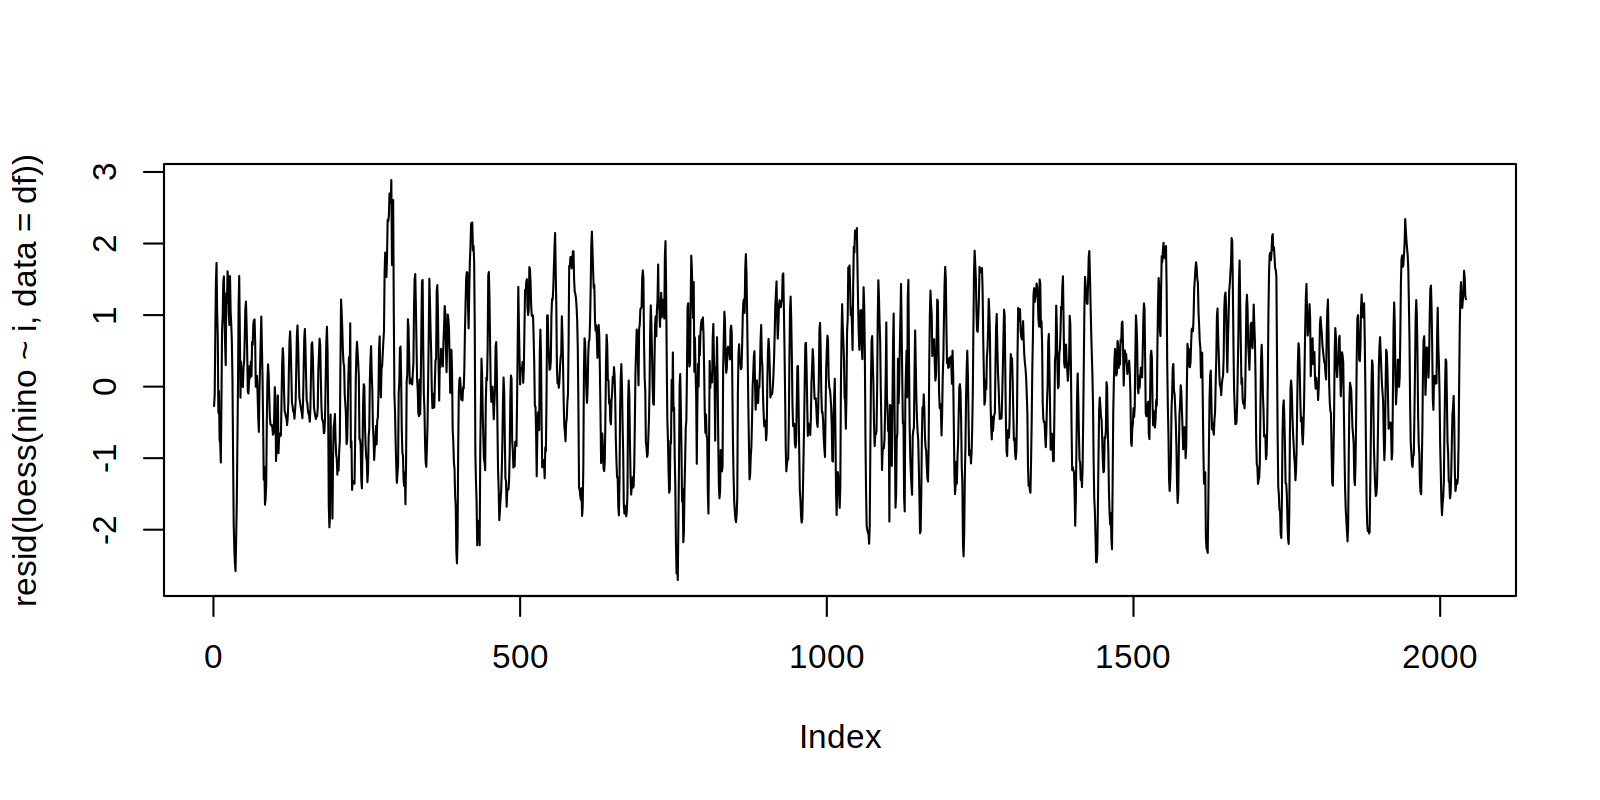

In [120]:
plot(resid(loess(nino ~ i, data = df)), type = "l")

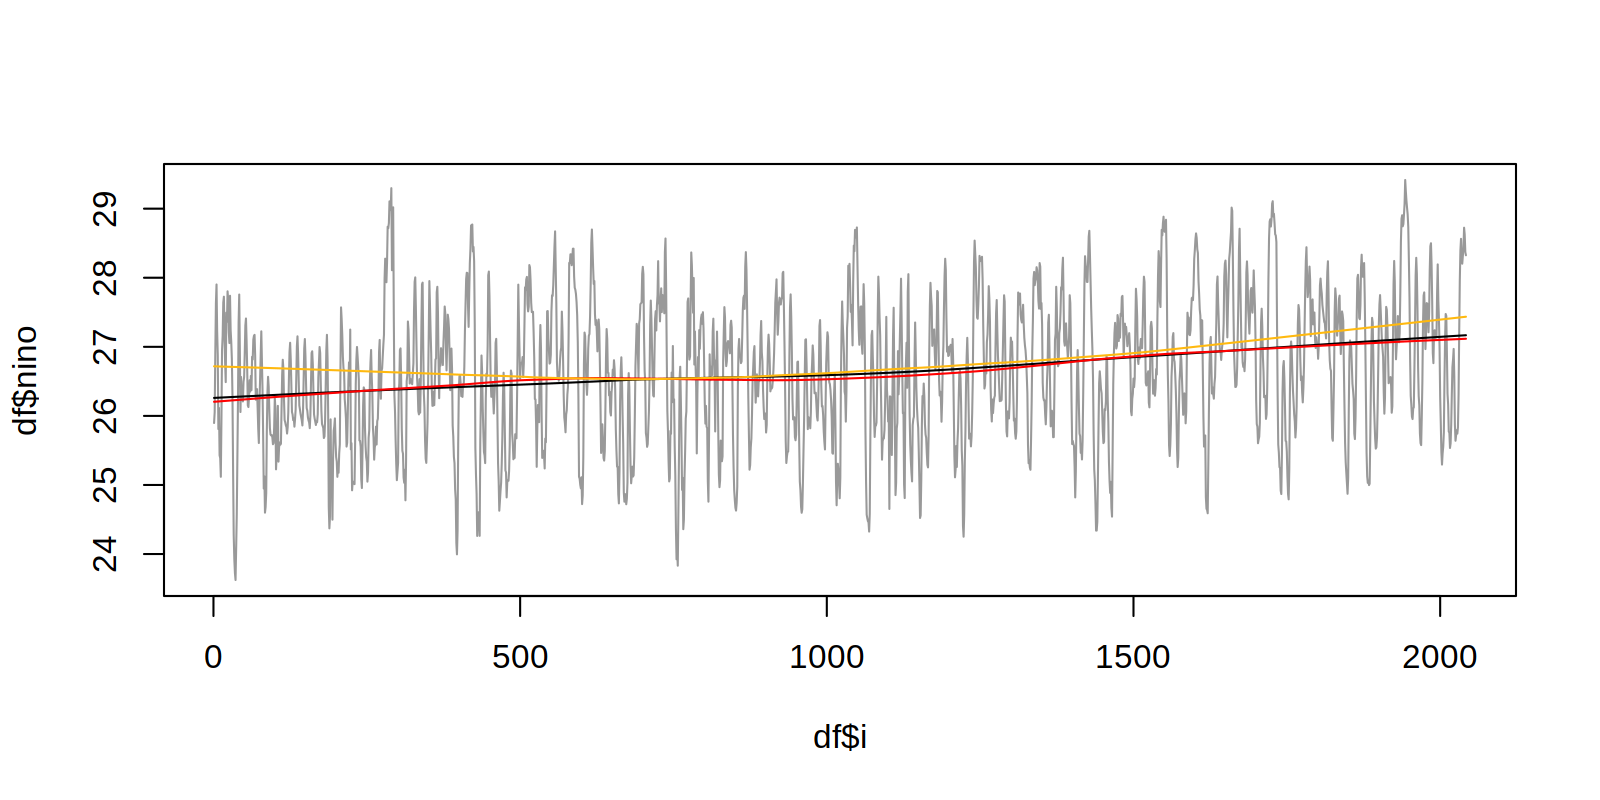

In [147]:
plot(df$i, df$nino, type = "l", col = adjustcolor("black", 0.4))
lines(lowess(df$i, df$nino))
# lines(df$i, df$nino_filt48, col = "blue")
lines(df$i, fitted(loess(nino ~ i, data = df, degree = 1, span = 0.5)), col = "red")
lines(df$i, fitted(loess(tsst ~ i, data = df, degree = 1, span = 0.5)), col = "darkgoldenrod1")